# Lecture 22 – Data 100, Fall 2024

Data 100, Fall 2024

[Acknowledgments Page](https://ds100.org/fa24/acks/)

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates["plotly"].layout.colorway = px.colors.qualitative.Vivid
px.defaults.width = 800

from scipy.optimize import minimize
import sklearn.linear_model as lm
from sklearn.metrics import r2_score


In this lecture, we will work with the `basketball` dataset, which contains information about basketball games played in the NBA. In the cell below, we perform data cleaning to transform the data into a useful form, which we store as the DataFrame `games`. 

Our goal in this portion of the lecture is to predict whether or not a team wins their game (`"WON"`) given their `"GOAL_DIFF"`. The variable `"GOAL_DIFF"` represents the difference in successful field goal rates between the two teams competing in a game. A positive value for `"GOAL_DIFF"` means that a team made more field goals than their opponent; a negative value means that the opponent made more field goals.

In [2]:
basketball = pd.read_csv("data/nba.csv")
basketball.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME   GAME_ID  \
0      22017  1610612744               GSW   Golden State Warriors  21700002   
1      22017  1610612745               HOU         Houston Rockets  21700002   
2      22017  1610612738               BOS          Boston Celtics  21700001   
3      22017  1610612739               CLE     Cleveland Cavaliers  21700001   
4      22017  1610612750               MIN  Minnesota Timberwolves  21700011   

    GAME_DATE      MATCHUP WL  MIN  FGM  ...  DREB  REB  AST  STL  BLK  TOV  \
0  2017-10-17  GSW vs. HOU  L  240   43  ...    35   41   34    5    9   17   
1  2017-10-17    HOU @ GSW  W  240   47  ...    33   43   28    9    5   13   
2  2017-10-17    BOS @ CLE  L  240   36  ...    37   46   24   11    4   12   
3  2017-10-17  CLE vs. BOS  W  240   38  ...    41   50   19    3    4   17   
4  2017-10-18    MIN @ SAS  L  240   37  ...    31   42   23    7    4   13   

   PF  PTS  PLUS_MINUS  VIDEO_AVAILABLE  
0  25  121          -1                1  
1  16  122           1                1  
2  24   99          -3                1  
3  25  102           3                1  
4  16   99          -8                1  

[5 rows x 29 columns]

In [3]:
basketball = pd.read_csv("data/nba.csv")
first_team = basketball.groupby("GAME_ID").first()
second_team = basketball.groupby("GAME_ID").last()
games = first_team.merge(second_team, left_index = True, right_index = True, suffixes = ["", "_OPP"])
games['GOAL_DIFF'] = games["FG_PCT"] - games["FG_PCT_OPP"]
games['WON'] = (games['WL'] == "W").astype(int)
games = games[['TEAM_NAME', 'TEAM_NAME_OPP', 'MATCHUP', 'WON', 'WL', 'GOAL_DIFF']]
games

TEAM_NAME           TEAM_NAME_OPP      MATCHUP  WON WL  \
GAME_ID                                                                        
21700001         Boston Celtics     Cleveland Cavaliers    BOS @ CLE    0  L   
21700002  Golden State Warriors         Houston Rockets  GSW vs. HOU    0  L   
21700003      Charlotte Hornets         Detroit Pistons    CHA @ DET    0  L   
21700004         Indiana Pacers           Brooklyn Nets  IND vs. BKN    1  W   
21700005          Orlando Magic              Miami Heat  ORL vs. MIA    1  W   
...                         ...                     ...          ...  ... ..   
21701226   New Orleans Pelicans       San Antonio Spurs  NOP vs. SAS    1  W   
21701227  Oklahoma City Thunder       Memphis Grizzlies  OKC vs. MEM    1  W   
21701228            LA Clippers      Los Angeles Lakers  LAC vs. LAL    0  L   
21701229              Utah Jazz  Portland Trail Blazers    UTA @ POR    0  L   
21701230        Houston Rockets        Sacramento Kings    HOU @ SAC    0  L   

          GOAL_DIFF  
GAME_ID              
21700001     -0.049  
21700002      0.053  
21700003     -0.030  
21700004      0.041  
21700005      0.042  
...             ...  
21701226      0.189  
21701227      0.069  
21701228      0.017  
21701229     -0.090  
21701230     -0.097  

[1230 rows x 6 columns]

## Logistic Regression

If we visualize our data, we see a very different result from the scatter plots we have worked with for linear regression. Because a team can only win or lose a game, the only possible values of `"WON"` are 1 (if the team won the game) or 0 (if the team lost).

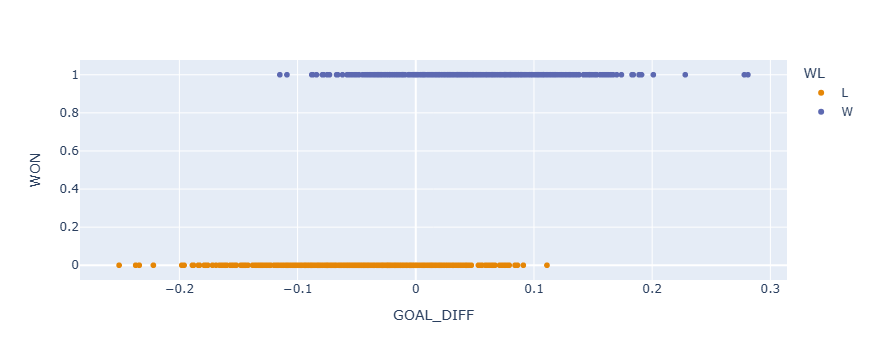

In [4]:
px.scatter(games, 
           x="GOAL_DIFF", y="WON", color="WL", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])

Because the only possible values of `"WON"` are 0 or 1, the visualization above shows significant overplotting. We can use **strip plot** to jitter the $y$ data by adding a small amount of random noise. This makes the plot easier to interpret and gives us nice colors for 0 and 1.

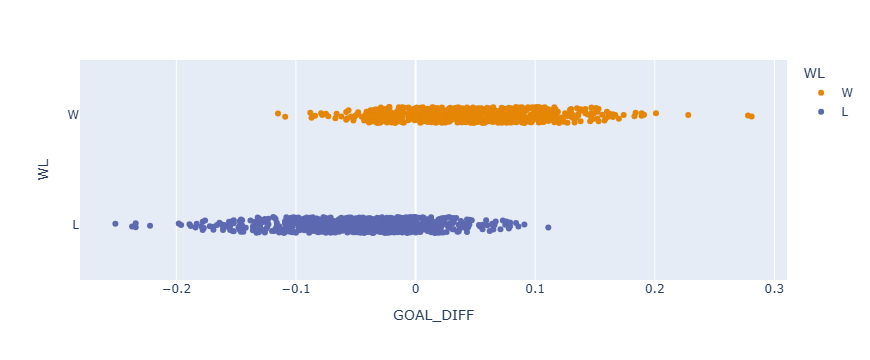

In [5]:
px.strip(games, x="GOAL_DIFF", y="WL", color="WL", 
         hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'],
         category_orders={"WL": ["W", "L"]})
# sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", order=[1, 0], hue="WON");

However, we can't plot lines on-top of this plot because the $y$ values are not continuous. Instead, we will jitter our label's directly to help with future visualizations.

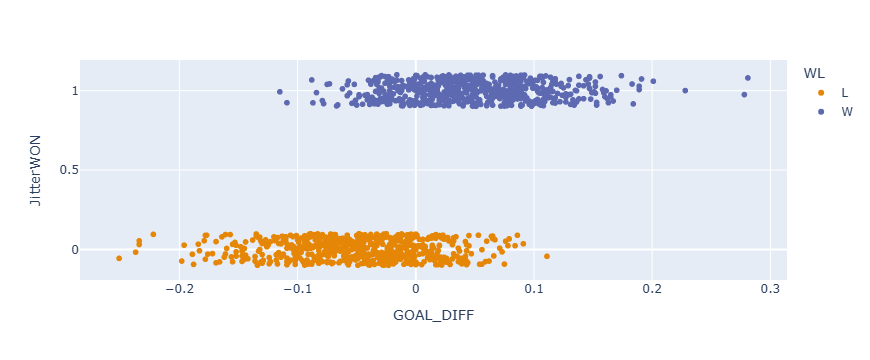

In [6]:
np.random.seed(42)
games["JitterWON"] = games["WON"] + np.random.uniform(-0.1, 0.1, len(games))
px.scatter(games, 
           x="GOAL_DIFF", y="JitterWON", color="WL", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])

Least squares linear regression, which is intended to output *continuous* numeric predictions, works poorly here (perhaps unsurprisingly).

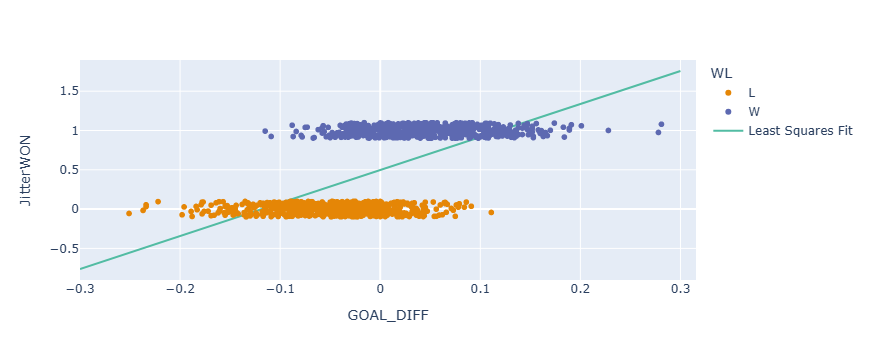

In [7]:
# Fitting a linear regression model to the data
X = games[["GOAL_DIFF"]]
Y = games["WON"]
least_squares_model = lm.LinearRegression()
least_squares_model.fit(X, Y)

# Make some predictions for a range of GOAL_DIFF values
pred = pd.DataFrame({"GOAL_DIFF": np.linspace(-0.3, 0.3)})
pred["LS_Pred"] = least_squares_model.predict(pred)

# Visualize the model
fig = px.scatter(games, 
           x="GOAL_DIFF", y="JitterWON", color="WL", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])
fig.add_trace(go.Scatter(x=pred["GOAL_DIFF"], y=pred["LS_Pred"], 
                         mode="lines", name="Least Squares Fit"))

The least squares linear regression won't work here. We will need a new approach to modeling.

<br><br><br>

**Return to Lecture**

<br><br><br>



Back in Data 8, you built up your understanding of linear regression by first considering the [graph of averages](https://inferentialthinking.com/chapters/08/1/Applying_a_Function_to_a_Column.html#example-prediction). We construct a graph of averages by *binning* all $x$ data into bins of similar values, then computing the average value of $y$ for each bin. This gives us a rough indication of the relationship between $x$ and $y$.

Let's try this on our dataset.

In [8]:
# Break our GOAL_DIFF values into 20 bins
bins, cuts = pd.cut(games["GOAL_DIFF"], 20, retbins=True)
    # Bins contains the lower, upper values for the interval for that row
    # Cuts contains the unique bin edges

# Lets look at a few of the bins
games.join(bins, rsuffix="_bins").head()

TEAM_NAME        TEAM_NAME_OPP      MATCHUP  WON WL  \
GAME_ID                                                                     
21700001         Boston Celtics  Cleveland Cavaliers    BOS @ CLE    0  L   
21700002  Golden State Warriors      Houston Rockets  GSW vs. HOU    0  L   
21700003      Charlotte Hornets      Detroit Pistons    CHA @ DET    0  L   
21700004         Indiana Pacers        Brooklyn Nets  IND vs. BKN    1  W   
21700005          Orlando Magic           Miami Heat  ORL vs. MIA    1  W   

          GOAL_DIFF  JitterWON      GOAL_DIFF_bins  
GAME_ID                                             
21700001     -0.049  -0.025092  (-0.0648, -0.0382]  
21700002      0.053   0.090143    (0.0416, 0.0682]  
21700003     -0.030   0.046399  (-0.0382, -0.0116]  
21700004      0.041   1.019732     (0.015, 0.0416]  
21700005      0.042   0.931204    (0.0416, 0.0682]

We can visualize the bins:

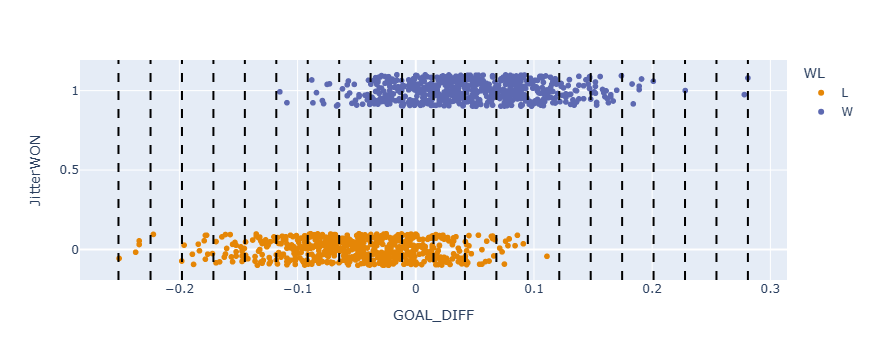

In [9]:
fig = px.scatter(games, 
           x="GOAL_DIFF", y="JitterWON", color="WL", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])
for cut in cuts:
    fig.add_vline(x=cut, line_dash="dash", line_color="black")

fig.show()

For each bin we can compute the win rate within that bin.  We do this by grouping the data according to which center of bin each row is assigned.

In [10]:
# Compute the bin center for every game (dot in the above plot)
games['bin_center'] = bins.apply(lambda x: (x.left + x.right)/2).astype(float)
# Now all the games that are in the same bin will have the same bin_center. 
# We can group by bin center and compute the average of the label to 
# get the win rate for each bin.
win_rates_by_bin = (
    games[["bin_center", "WON"]]
    .groupby("bin_center") 
    .mean()
    .rename(columns={"WON": "Win Rate"})
)
win_rates_by_bin 

Win Rate
bin_center          
-0.2380     0.000000
-0.2110     0.000000
-0.1845     0.000000
-0.1580     0.000000
-0.1315     0.000000
-0.1047     0.033898
-0.0781     0.083333
-0.0515     0.148438
-0.0249     0.363636
 0.0017     0.505747
 0.0283     0.705128
 0.0549     0.792793
 0.0815     0.907407
 0.1079     0.984615
 0.1345     1.000000
 0.1615     1.000000
 0.1880     1.000000
 0.2410     1.000000
 0.2675     1.000000

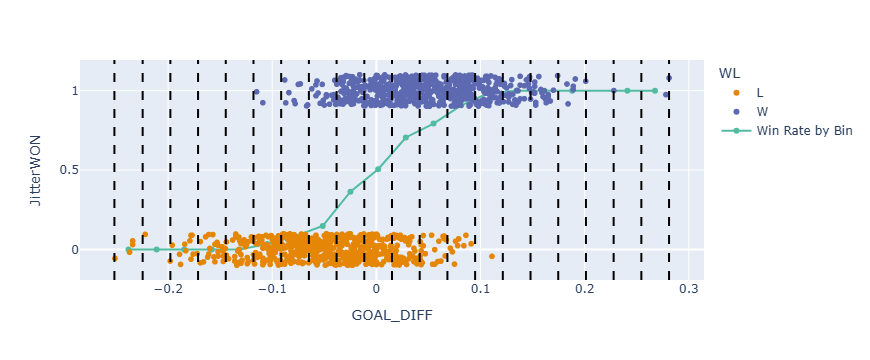

In [11]:
# Visualize the model
fig = px.scatter(games, 
           x="GOAL_DIFF", y="JitterWON", color="WL", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])
fig.add_trace(go.Scatter(x=win_rates_by_bin.index, y=win_rates_by_bin['Win Rate'], 
                         mode="markers+lines", name="Win Rate by Bin"))
for cut in cuts:
    fig.add_vline(x=cut, line_dash="dash", line_color="black")

fig.show()

Our graph of averages has revealed a S-shaped curve. This doesn't look like anything we've encountered before!

<br><br><br>

**Return to Lecture**

<br><br><br>




The relationship between $x$ (`"GOAL_DIFF"`) and $y$ (`"WON"`) shows clear non-linearity. To apply the linear modeling techniques we've explored previously, we will need to *linearize* the relationship. Recall our previous approach to transforming variables:

1. Apply transformations to linearize the relationship between our variables of interest.
2. Fit a linear regression model to the transformed data.
3. "Un-transform" our data to recover the underlying relationship between the original variables.

First, we need to decide what transformations we will perform. The S-shaped curve above doesn't resemble our bulge diagram, so we must apply a new transformation to linearize the relationship.

To determine what this transformation should be, we make a few observations:
* All predictions on our curve are between 0 and 1.
* To compute the average for each bin, we calculated: $\frac{\#\:Y=1\:\text{in bin}}{\#\:\text{datapoints in bin}} = P(Y=1 | \text{bin})$.

Together, these observations indicate that our graph of averages is *actually* modeling the probability of a data point having $Y = 1$! Rather than predicting any continuous numeric output, we now want to predict the *probability* of a datapoint belonging to Class 1 (i.e., the team winning the game). 

To determine if it is "likely" that a data point belongs to Class 1, we can consider the **odds**: 

$$\text{odds} = \frac{P(Y=1|x)}{P(Y=0|x)} = \frac{P(Y=1|x)}{1-P(Y=1|x)} = \frac{p}{1-p}$$

Here, we use $p$ to denote the probability of a datapoint belonging to Class 1. A large odds value means that it is more likely than not that the data point belongs to Class 1.

In [12]:
win_rates_by_bin.index.name = "GOAL_DIFF"
win_rates_by_bin["odds"] = win_rates_by_bin["Win Rate"]/(1-win_rates_by_bin["Win Rate"])
win_rates_by_bin

Win Rate       odds
GOAL_DIFF                     
-0.2380    0.000000   0.000000
-0.2110    0.000000   0.000000
-0.1845    0.000000   0.000000
-0.1580    0.000000   0.000000
-0.1315    0.000000   0.000000
-0.1047    0.033898   0.035088
-0.0781    0.083333   0.090909
-0.0515    0.148438   0.174312
-0.0249    0.363636   0.571429
 0.0017    0.505747   1.023256
 0.0283    0.705128   2.391304
 0.0549    0.792793   3.826087
 0.0815    0.907407   9.800000
 0.1079    0.984615  64.000000
 0.1345    1.000000        inf
 0.1615    1.000000        inf
 0.1880    1.000000        inf
 0.2410    1.000000        inf
 0.2675    1.000000        inf

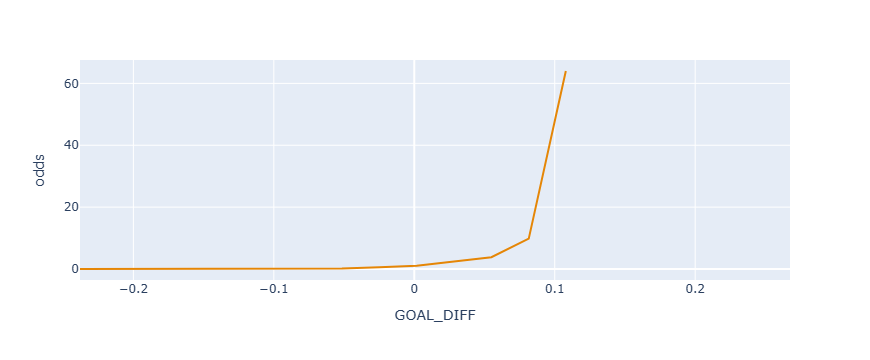

In [13]:
px.line(win_rates_by_bin, y="odds")

Interesting – the relationship between the odds and our `"GOAL_DIFF"` feature appears exponential. Let's "undo" this exponential trend by taking the logarithm.

As a reminder, you should always assume that any logarithm in Data 100 is base $e$ (the natural log) unless told otherwise.

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log



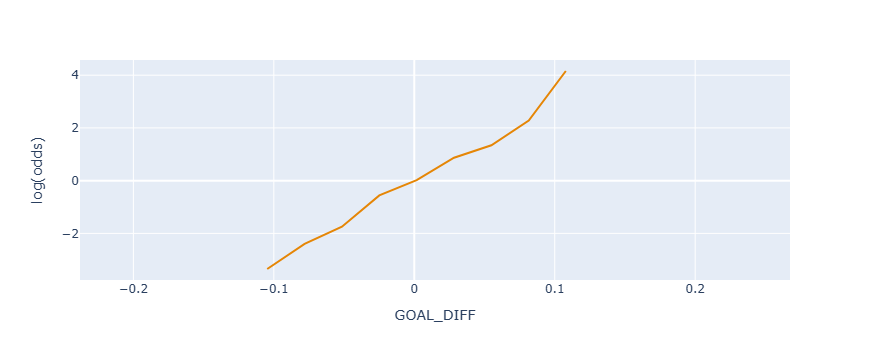

In [14]:
win_rates_by_bin["log(odds)"] = np.log(win_rates_by_bin["odds"])
px.line(win_rates_by_bin, y="log(odds)")

Putting all of our plots together:

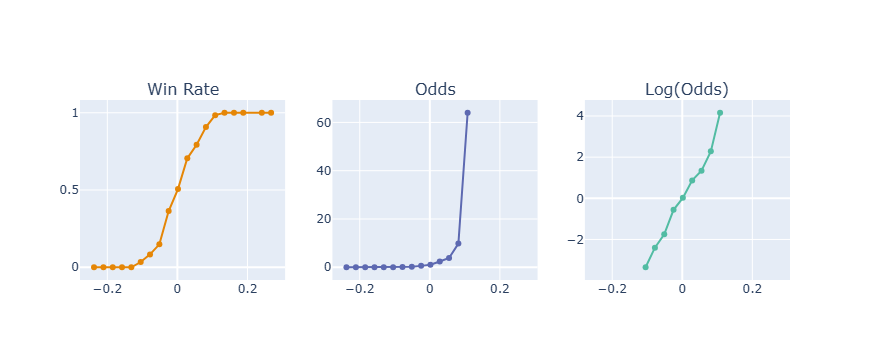

In [15]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=("Win Rate", "Odds", "Log(Odds)"))
fig.add_trace(go.Scatter(x=win_rates_by_bin.index, y=win_rates_by_bin['Win Rate'],  mode="markers+lines"), row=1, col=1)
fig.add_trace(go.Scatter(x=win_rates_by_bin.index, y=win_rates_by_bin['odds'], mode="markers+lines"), row=1, col=2)
fig.add_trace(go.Scatter(x=win_rates_by_bin.index, y=win_rates_by_bin['log(odds)'], mode="markers+lines"), row=1, col=3)
fig.update_layout(showlegend=False)

We've found a linear relationship! It turns out that the logarithm of the odds shares a linear relationship with our `"GOAL_DIFF"` feature. This means that we can express the log odds as a linear combination of the features:

$$\log{(\frac{p}{1-p})}=x^T \theta$$

Now, we can "undo" our transformations to recover the underlying relationship between the `"GOAL_DIFF"` and the probability of the datapoint belonging to Class 1. In the work below, $x^T$ represents the row vector containing all features for the $i$th datapoint. We can express our linear regression fit as a linear combination of the model parameters, $x^T \theta$.

$$\begin{align}
x^T \theta &= \log{\frac{p}{1-p}}\\
e^{x^T \theta} &= \frac{p}{1-p}\\
(1-p)e^{x^T \theta} &= p\\
e^{x^T \theta}- p e^{x^T \theta} &= p\\
e^{x^T \theta} &= p(1 + e^{x^T \theta})\\
p &= \frac{e^{x^T \theta}}{1+e^{x^T \theta}}\\
p &= \frac{1}{1+e^{-x^T \theta}}\\
\end{align}$$

Hence, the model's output – the predicted probability that the $i$-th data point belongs to Class 1, is given by:

$$\hat{y} = P(Y=1|x_i) = \frac{1}{1+e^{-x_i^T \theta}}$$

The expression $\frac{1}{1+e^{-z}}$ is known as the **sigmoid** or **logistic** function, and typically represented as $\sigma(z)$. We can therefore equivalently express our model as $\hat{y} = P(Y=1|x) = \sigma(x^T \theta)$. This model is known as the **logistic regression model**.

When we fit a logistic regression model to our data, we produce the S-shaped curve generated by the graph of averages!

In [16]:
logistic_model = lm.LogisticRegression(C=20)
logistic_model.fit(X, Y)
pred["Logistic_Pred"] = logistic_model.predict_proba(pred[["GOAL_DIFF"]])[:,1]

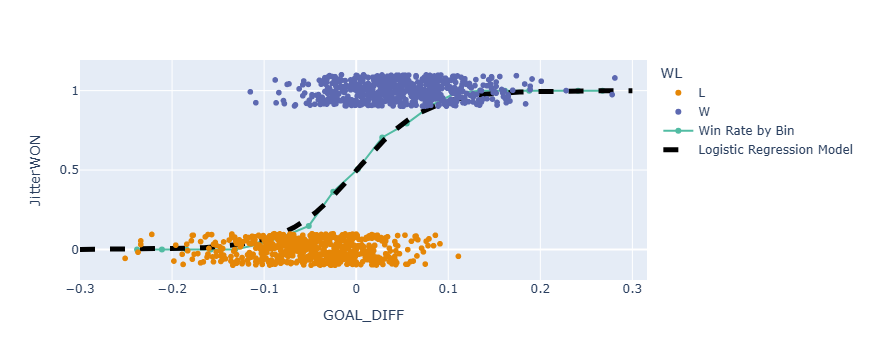

In [17]:
# Visualize the model
fig = px.scatter(games, 
           x="GOAL_DIFF", y="JitterWON", color="WL", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])
# Add the binned predictions
fig.add_trace(go.Scatter(x=win_rates_by_bin.index, y=win_rates_by_bin['Win Rate'], 
                         mode="markers+lines", name="Win Rate by Bin"))
# Add the logistic regression model predictions
fig.add_trace(go.Scatter(x=pred["GOAL_DIFF"], y=pred["Logistic_Pred"], 
                         mode="lines", name="Logistic Regression Model", 
                         line_color="black", line_width=5, line_dash="dash"))

# for cut in cuts:
#     fig.add_vline(x=cut, line_dash="dash", line_color="black")

fig.show()

<br><br><br>

**Return to Lecture**

<br><br><br>

## Cross-Entropy Loss

To select model parameters for our logistic regression model, we will need to choose a loss function. We might be inclined to use our familiar mean squared error. It turns out this is a bad idea.

In the cell below, we artificially generate a "toy" dataset to play with as we explore the loss of a logistic regression model. We'll try to use the `"x"` feature to predict the `"y"` target.

In [18]:
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]
})
toy_df["str_y"] = toy_df["y"].astype(str)
toy_df.sort_values("x")

x  y str_y
0 -4.0  0     0
1 -2.0  0     0
2 -0.5  1     1
3  1.0  0     0
4  3.0  1     1
5  5.0  1     1

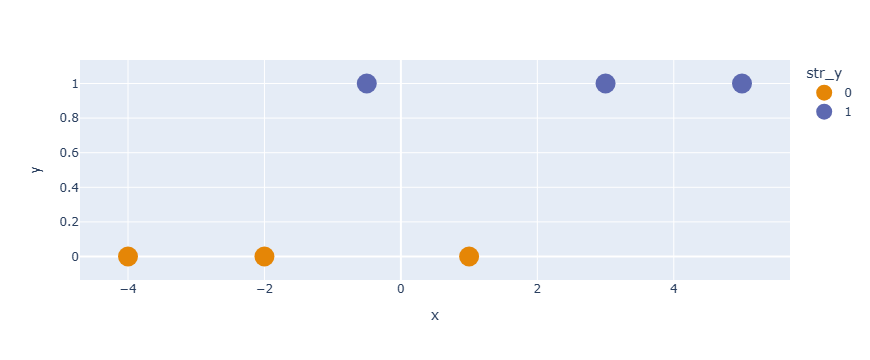

In [19]:
fig = px.scatter(toy_df, x="x", y="y", color="str_y", width=800)
fig.update_traces(marker_size=20)

Let's plot the loss surface for this toy data using MSE with the model $\hat{y} = \sigma(x.\theta)$. We don't include an intercept term, so $\theta$ and $x$ are both scalars.

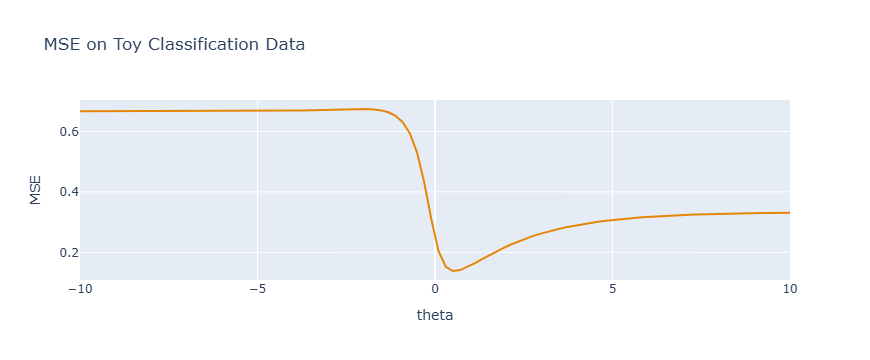

In [20]:
def sigmoid(z):
    return 1/(1+np.e**-z)

def mse_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

theta_loss = pd.DataFrame({"theta": np.linspace(-10, 10, 100)})
theta_loss["MSE"] = theta_loss["theta"].apply(mse_on_toy_data)
px.line(theta_loss, x="theta", y="MSE", width=800,
        title="MSE on Toy Classification Data")

This loss surface is not convex! There are both local and global minima in the loss surface. This means that, depending on where we start our optimization search, we'll end up with different results for the optimizing $\theta$. Let's explore with `scipy.optimize.minimize`.

In [21]:
# Set the initial guess as theta = 0
best_theta = minimize(mse_on_toy_data, x0 = 0)["x"][0]
best_theta

0.5446601825581691

This "optimized" value of $\theta$ produces the following model when we apply it to our model $\hat{y} = \sigma(\theta x )$.

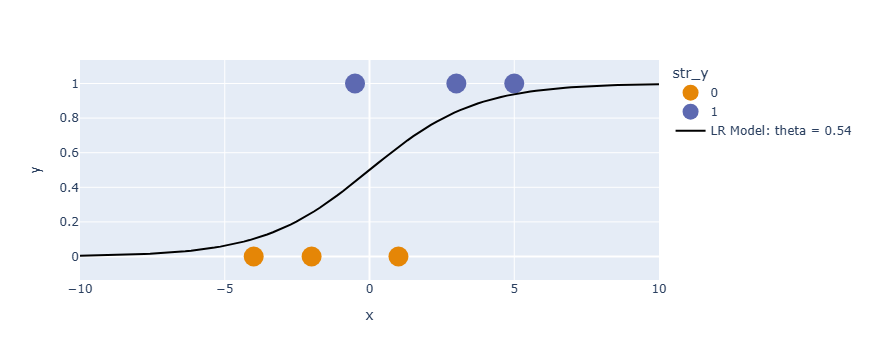

In [22]:
fig = px.scatter(toy_df, x="x", y="y", color="str_y", width=800)
xs = np.linspace(-10, 10, 100)
fig.add_trace(go.Scatter(
    x=xs, y=sigmoid(xs * best_theta), 
    mode="lines", line_color="black", 
    name=f"LR Model: theta = {best_theta:.2f}"))
fig.update_traces(marker_size=20)


Let's try a different starting point for the initial guess for the minimizing parameter value.

In [23]:
# Set the initial guess as theta = -5
best_theta_2 = minimize(mse_on_toy_data, x0 = -5)["x"][0]
best_theta_2

-10.343653061026611

Uh oh, looks like the optimizer got stuck at a local minimum of the loss surface. If we use this guess for the optimal $\theta$ in our logistic regression model, we see strange behavior.

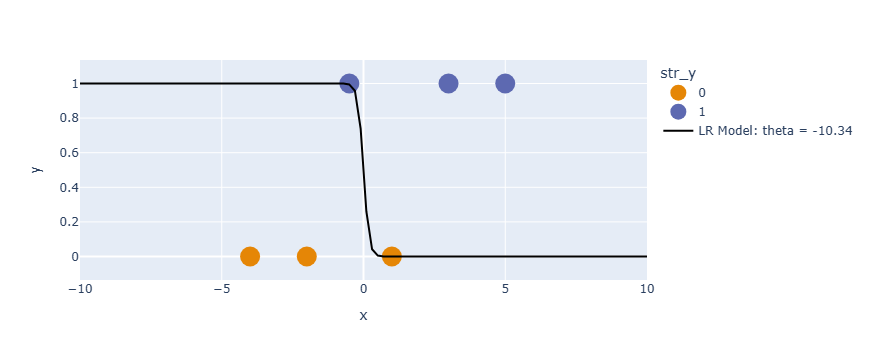

In [24]:
fig = px.scatter(toy_df, x="x", y="y", color="str_y", width=800)
xs = np.linspace(-10, 10, 100)
fig.add_trace(go.Scatter(
    x=xs, y=sigmoid(xs * best_theta_2), 
    mode="lines", line_color="black", 
    name=f"LR Model: theta = {best_theta_2:.2f}"))
fig.update_traces(marker_size=20)


To see what went wrong, let's plot these two "optimized" guess for $\hat{\theta}$ on the original loss surface. They correspond to the local and global minimum of the loss surface.

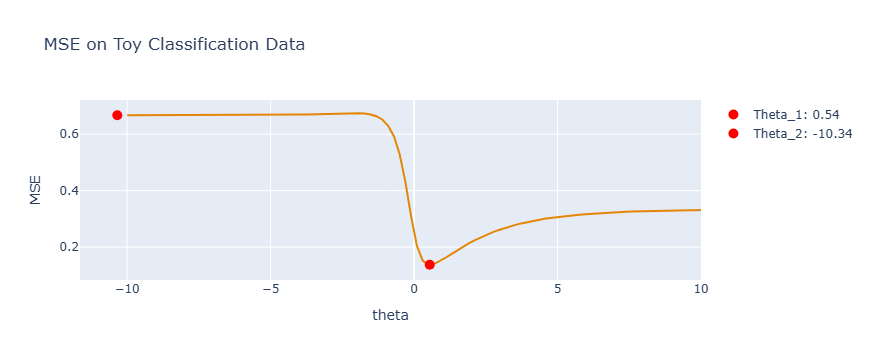

In [25]:
fig = px.line(theta_loss, x="theta", y="MSE", width=800,
              title="MSE on Toy Classification Data")
fig.add_scatter(x=[best_theta], y=[mse_on_toy_data(best_theta)], 
                mode="markers", marker_size=10, marker_color="red",
                name=f"Theta_1: {best_theta:.2f}")
fig.add_scatter(x=[best_theta_2], y=[mse_on_toy_data(best_theta_2)], 
                mode="markers", marker_size=10, marker_color="red",
                name=f"Theta_2: {best_theta_2:.2f}")

We've seen now that the fact that MSE is not convex for logistic regression leads to difficulty in optimizing $\hat{\theta}$. 

Beyond this issue, the squared loss isn't well-suited for a probability task. Since $\hat{p}_i$ is between 0 and 1, and $y_i$ is either 0 or 1, the squared loss for a single point $(y_i - \hat{p}_i)^2$ is bounded between 0 and 1.

What this means in practice: Even if our prediction is terrible, the squared loss is never that large. Consider the "worst-case scenario" where the true class $y_i$ of datapoint $i$ is 0, and the model predicts a probability $p_i=1$ that this datapoint belongs to Class 1. Even though our model has made the worst possible prediction, the squared loss is only $(0-1)^2=1$!

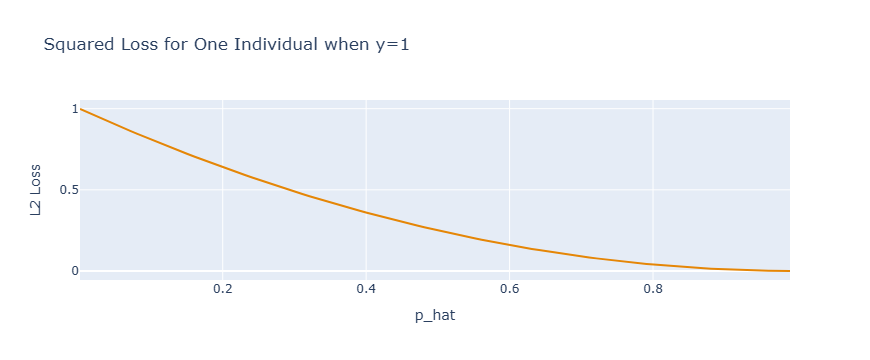

In [26]:
p_hat_loss = pd.DataFrame({"p_hat": np.arange(0.001, 0.999, 0.01)}) 
p_hat_loss["L2 Loss"] = (1 - p_hat_loss["p_hat"])**2
px.line(p_hat_loss, x="p_hat", y="L2 Loss", width=800,
        title="Squared Loss for One Individual when y=1")

### Motivating Cross-Entropy Loss

Let's look at a new loss, called the **negative log loss**, for when our true observation is 1. We define the loss on a single datapoint as $l = -\log{p}$.

In [27]:
p_hat_loss["Neg Log Loss"] = -np.log(p_hat_loss["p_hat"])

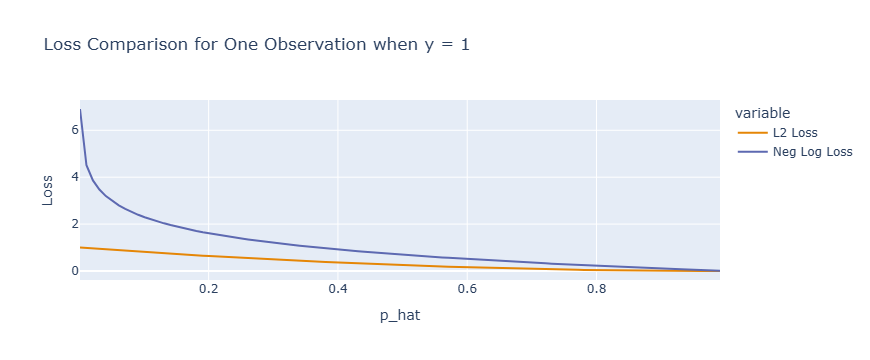

In [28]:
px.line(p_hat_loss.melt(id_vars="p_hat", value_name="Loss"), 
        x="p_hat", y="Loss", color="variable", width=800,
        title="Loss Comparison for One Observation when y = 1")

We can see that this penalizes wrong predictions far more than squared loss does.

How to read this plot: suppose the observation we're trying to predict is actually in Class 1. If our model gives an 80% chance of being in Class 1, the loss is relatively small (around 0.25). 

* If we predict only a 40% chance of being in Class 1, the loss is larger (around 1).
* If we predict only a 5% chance of being in Class 1, the loss is 3.
* And if we give a 0% chance of being in Class 1, the loss is infinite.

What about when the true observation is 0? Consider the single-datapoint loss given by $l=-\log{(1-p)}$.

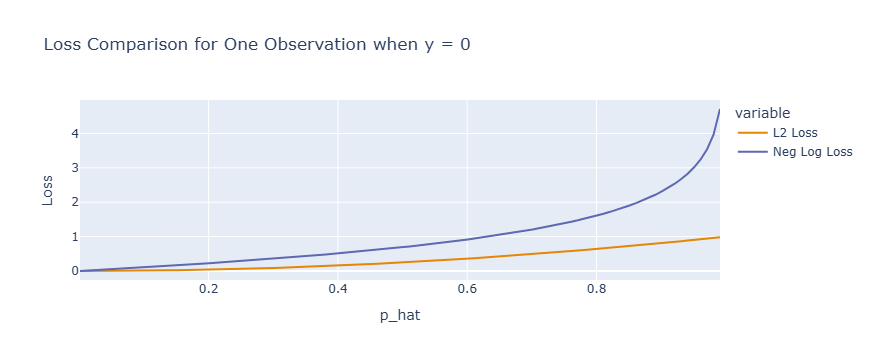

In [29]:
p_hat_loss = pd.DataFrame({"p_hat": np.arange(0.001, 0.999, 0.01)}) 
p_hat_loss["L2 Loss"] = (1 - (1-p_hat_loss["p_hat"]))**2
p_hat_loss["Neg Log Loss"] = -np.log(1 - p_hat_loss["p_hat"])
px.line(p_hat_loss.melt(id_vars="p_hat", value_name="Loss"), 
        x="p_hat", y="Loss", color="variable", width=800,
        title="Loss Comparison for One Observation when y = 0")

Much of the formal derivation is in the slides. The equation for cross-entropy loss for a single observation is:

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y}) = -\left(y \log(\hat{y}) + (1-y)\log(1-\hat{y})\right)$$

For us, since $\hat{y} = \sigma(x^T \theta)$, the expression for average cross-entropy loss is:

$$R(\theta) = -\frac{1}{n} \sum_{i = 1}^n \big(y_i \log (\sigma(\mathbb{X}_i^T \theta)) + (1 - y_i) \log (1 - \sigma(\mathbb{X}_i^T \theta))\big)$$

Let's look at the loss surface for average cross-entropy loss on our toy data from before.

In [30]:
def cross_entropy(y, p_hat):
    return - y * np.log(p_hat) - (1 - y) * np.log(1 - p_hat)
def mean_cross_entropy_on_toy_data(theta):
    p_hat = sigmoid(toy_df["x"] * theta)
    return np.mean(cross_entropy(toy_df["y"], p_hat))

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

C:\Users\siriusyz\.conda\envs\cs189\Lib\site-pac

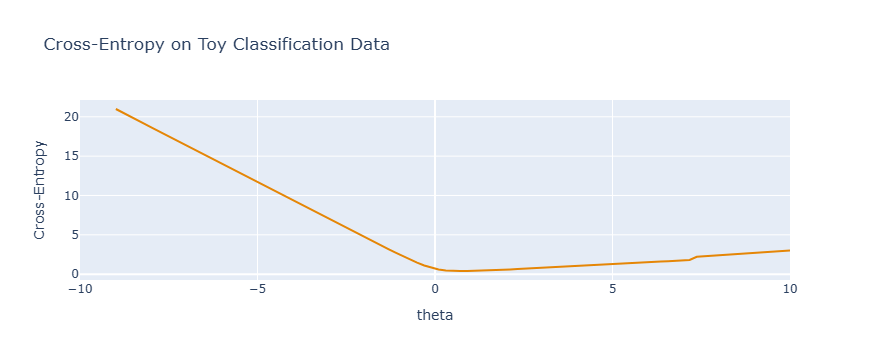

In [31]:
theta_loss["Cross-Entropy"] = theta_loss["theta"].apply(mean_cross_entropy_on_toy_data).dropna()
px.line(theta_loss, x="theta", y="Cross-Entropy", width=800,
           title="Cross-Entropy on Toy Classification Data")

We go ta bunch of error messages.  While the above equations are correct, they are not numerically stable.  We need to rewrite the loss function in a more numerically stable way.

**The following derivation is out-of-scope for data 100 but good to know for life.**

The following is a more numerically stable implementation of the cross-entropy loss let $z = \mathbb{X}_i^T \theta$ and using the identity $\log( 1-\sigma(z)) = -z + \log(\sigma(z))$:

\begin{align}
R(\theta) 
&= -\frac{1}{n} \sum_{i = 1}^n \left(y_i \log (\sigma(z)) + (1 - y_i) \log (1 - \sigma(z))\right)\\
&= -\frac{1}{n} \sum_{i = 1}^n \left(y_i \log (\sigma(z)) + (1 - y_i) \left( -z + \log (\sigma(z))\right)\right)\\
&= -\frac{1}{n} \sum_{i = 1}^n \left(y_i \log (\sigma(z)) - z + \log \left(\sigma(z) \right)+ y_i z  - y_i\log \left(\sigma(z) \right)  \right)\\
&= -\frac{1}{n} \sum_{i = 1}^n \left( \left(y_i - 1 \right)z + \log \left(\sigma(z) \right)   \right)\\
\end{align}

We can further optimize this by using the identity $\log(\sigma(z)) = -\log(1 + e^{-z})$ and applying more numerically stable log implementations:

\begin{align}
R(\theta) 
&= -\frac{1}{n} \sum_{i = 1}^n \left( \left( y_i - 1\right)z - \log(1 + e^{-z})   \right)\\
\end{align}


In [32]:
def mean_cross_entropy_on_toy_data(theta):
    y = toy_df["y"]
    z = toy_df["x"] * theta
    # using the log1p numerically stable operation
    return -np.mean((y - 1) * z - np.log1p(np.exp(-z)))

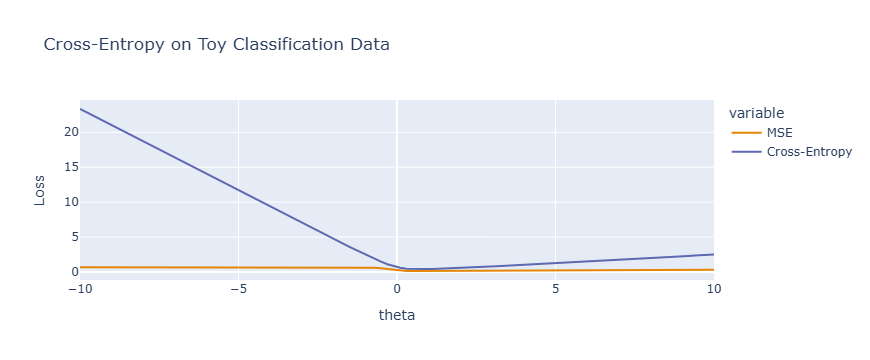

In [33]:
theta_loss["Cross-Entropy"] = theta_loss["theta"].apply(mean_cross_entropy_on_toy_data).dropna()
px.line(theta_loss.melt(id_vars="theta", value_name="Loss"), 
        x="theta", y="Loss", color="variable",
           title="Cross-Entropy on Toy Classification Data")

The above plot is convex!

In [34]:
best_ce_theta = minimize(mean_cross_entropy_on_toy_data, x0 = -5)["x"][0]
best_ce_theta

0.7432351324834428

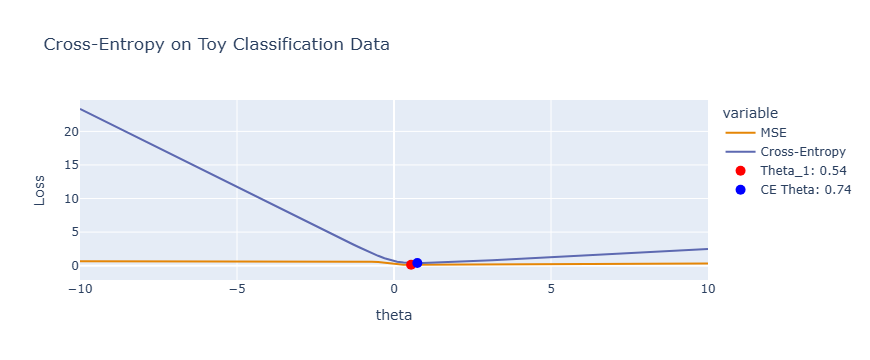

In [35]:
fig = px.line(theta_loss.melt(id_vars="theta", value_name="Loss"), 
              x="theta", y="Loss", color="variable",
              title="Cross-Entropy on Toy Classification Data")
fig.add_scatter(x=[best_theta], y=[mse_on_toy_data(best_theta)], 
                mode="markers", marker_size=10, marker_color="red",
                name=f"Theta_1: {best_theta:.2f}")
fig.add_trace(go.Scatter(x=[best_ce_theta], y=[mean_cross_entropy_on_toy_data(best_ce_theta)], 
                         mode="markers", marker_size=10, marker_color="Blue",
                         name=f"CE Theta: {best_ce_theta:.2f}"))

Finally, we can see what our new model looks like using the correct loss function.

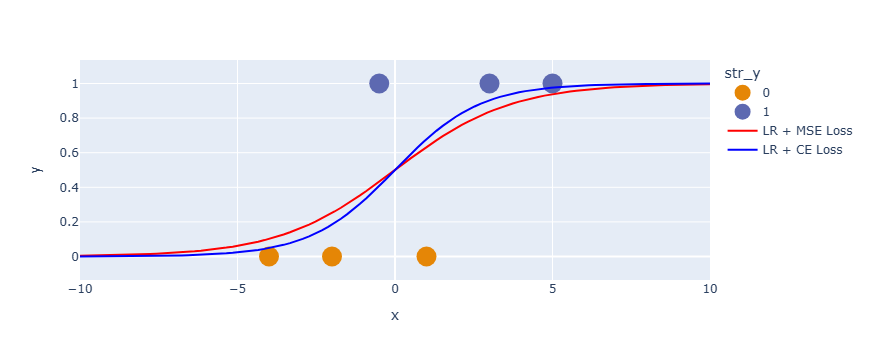

In [36]:
fig = px.scatter(toy_df, x="x", y="y", color="str_y", width=800)
xs = np.linspace(-10, 10, 100)
fig.add_trace(go.Scatter(
    x=xs, y=sigmoid(xs * best_theta), 
    mode="lines", line_color="red", 
    name=f"LR + MSE Loss"))
fig.add_trace(go.Scatter(
    x=xs, y=sigmoid(xs * best_ce_theta), 
    mode="lines", line_color="blue", 
    name=f"LR + CE Loss"))

fig.update_traces(marker_size=20)
